# Newton with line search

## [Michel Bierlaire](https://people.epfl.ch/michel.bierlaire), EPFL.

In [1]:
import numpy as np

# Line search algorithm

We implement first the inexact line search algorithm based on the two Wolfe conditions. This is Algorithm 11.5 in <a href="http://optimizationprinciplesalgorithms.com/">Bierlaire (2015) Optimization: principles and algorithms, EPFL Press.</a>

In [2]:
def lineSearch(obj, x, d, alpha0, beta1, beta2, lbd = 2):
    """
    :param obj: function returning the value of the objective function and its gradient.
    :type obj: f, g = fct(x)
    
    :param x: point where the line search starts.
    :type x: numpy array
    
    :param d: direction along which the line search is performed.
    :type d: numpy array (size dimension as x)
    
    :param alpha0: first trial for the step
    :type alpha0: float. Must be positive. 
    
    :param beta1: parameter for the first Wolfe condition. 
    :type beta1: float. Must be strictly between 0 and 1.
    
    :param beta2: parameter for the second Wolfe condition. 
    :type beta2: float. Must be strictly between 0 and 1, and beta2 > beta1.
    
    """
    if  lbd <= 1:
        raise Exception(f'lambda is {lbd} and must be > 1')
    if  alpha0 <= 0:
        raise Exception(f'alpha0 is {alpha0} and must be > 0')
    if beta1 <= 0 or beta1 >= 1:
         raise Exception(f'beta1 = {beta1} must be strictly between 0 and 1')
    if beta2 >= 1:
         raise Exception(f'beta2 = {beta2} must be strictly lesser than 1')       
    if  beta1 >= beta2:
        raise Exception(f'Incompatible Wolfe cond. parameters: beta1={beta1} is greater or equal than beta2={beta2}')
        
    f, g = obj(x)
    deriv = np.inner(g,d)
    if deriv >= 0:
        raise Exception(f'd is not a descent direction: {deriv} >= 0')
    i = 0
    alpha = alpha0
    # The lower bound alphal is initialized to 0.
    alphal = 0
    # The upper bound alphar is initialized to "infinity", that is, the largest floating point number
    # representable in the machine. 
    alphar = np.finfo(np.float64).max
    finished = False
    iters = list()
    while not finished:
        xnew = x + alpha * d
        fnew, gnew = obj(xnew)
        # First Wolfe condition
        if fnew > f + alpha * beta1 * deriv:
            reason = "too long"
            alphar = alpha ;
            alpha = (alphal + alphar) / 2.0
        # Second Wolfe condition
        elif np.inner(gnew, d) < beta2 * deriv:
            reason = "too short"
            alphal = alpha 
            if alphar == np.finfo(np.float64).max:
                alpha = lbd * alpha 
            else:
                alpha = (alphal + alphar) / 2.0
        else:
            reason = "ok"
            finished = True
        iters.append([alpha, alphal, alphar, reason])
    return alpha, iters

# Calculate a preconditioner and returns its Cholesky factor

We implement a modified Cholesky factorization, that modifies the matrix if it is not positive definite. This is Algorithm 11.7 in <a href="http://optimizationprinciplesalgorithms.com/">Bierlaire (2015) Optimization: principles and algorithms, EPFL Press.</a>

Given a square symmetric matrix $H$, we find a scalar $\tau \geq 0$ and a lower triangular matrix $L$ such that \\[ H + \tau I = L^T L. \\]

In [3]:
def modifiedCholesky(H):
    """
    :param H: a square symmetric matrix
    :type H: np.array 2D
    """
    tau = 0.0
    m, n = H.shape
    if m != n:
        raise Exception('The matrix must be square and not {m}x{n}.')
    if not (H.transpose() == H).all():
        raise Exception('The matrix must be symmetric.')

    frobeniusNorm = np.linalg.norm(H)
    if frobeniusNorm <= 1.0e-6:
        frobeniusNorm = 1.0e-6
    # Identify the smallest diagonal element
    mindiag = min(H.diagonal())
    if mindiag >= 0:
        # If non negative, we try tau = 0
        tau = 0
        R = H
    else:
        # If negative, we try tau = ||H||       
        tau = frobeniusNorm
        R = H + tau * np.eye(n)
    # We check if the matrix is positive definite using its eigen values.
    mineig = min(np.linalg.eigvalsh(R))
    while mineig <= 0:
        # If it is not positive definite, we update tau
        tau = max(2 * tau, 0.5 * frobeniusNorm)
        R = H + tau * np.eye(n)
        mineig = min(np.linalg.eigvalsh(R))
    return np.linalg.cholesky(R), tau

## Example

In [4]:
n = 3
H = np.array([[1, 3, 5], [3, 5, 7], [5, 7, 9]])
L, tau = modifiedCholesky(H)

In [5]:
H

array([[1, 3, 5],
       [3, 5, 7],
       [5, 7, 9]])

In [6]:
tau

8.261355820929152

In [7]:
L

array([[3.04324758, 0.        , 0.        ],
       [0.985789  , 3.50564914, 0.        ],
       [1.64298167, 1.53477046, 3.49377256]])

We can check that \\[ L^T L - H = \tau I. \\]

In [8]:
L @ L.T - H 

array([[8.26135582, 0.        , 0.        ],
       [0.        , 8.26135582, 0.        ],
       [0.        , 0.        , 8.26135582]])

Equivalently, \\[ L L^T - \tau I = H. \\]

In [9]:
L @ L.T - tau * np.eye(n)

array([[1., 3., 5.],
       [3., 5., 7.],
       [5., 7., 9.]])

# Preconditioned steepest descent

Given a lower triangular matrix $L$, find \\[ d = - (L L^T)^{-1} \nabla f(x_k) \\] by solving two triangular systems of equations: \\[ L z = \nabla f(x_k), \\] and \\[ L^T d = z.\\]

In [10]:
from scipy import linalg
def preconditionedSteepestDescent(L, g):
    z = linalg.solve_triangular(L, g, lower=True)
    d = linalg.solve_triangular(L.transpose(), -z)
    return d

# Newton with line search

We implement the Newton algorithm with line search. This is Algorithm 11.8 in <a href="http://optimizationprinciplesalgorithms.com/">Bierlaire (2015) Optimization: principles and algorithms, EPFL Press.</a>

In [11]:
def NewtonLineSearch(obj, x0, eps, maxiter = 10000):
    """
    :param obj: function returning the value of the objective function, its gradient and hessian.
    :type obj: f, g, H = fct(x)
    
    :param x0: starting point
    :type x: numpy array
    
    :param eps: requested precision
    :type eps: float
    """
    # First, we need a wrapper that returns only f and g for the line search
    def objls(x):
        f, g, _ = obj(x)
        return f, g
    
    xk = x0
    f, g, H = obj(xk)
    k = 0
    iters = [[xk, None, None, None]]
    while np.linalg.norm(g) > eps and k <= maxiter:
        f, g, H = obj(xk)
        L, tau = modifiedCholesky(H)
        d = preconditionedSteepestDescent(L, g)
        alpha, it = lineSearch(objls, xk, d, alpha0 = 1.0, beta1 = 1.0e-4, beta2 = 0.99)
        xk = xk + alpha*d
        k = k + 1
        iters.append([xk, d, tau, alpha])
    opt = xk
    if k == maxiter:
        print(f'Maximum number of iteration {maxiter} reached')
    return opt, iters

# Rosenbrock function

The Rosenbrock function is defined as \\[ f(x_1, x_2) = 100 (x_2-x_1^2)^2 + (1-x_1)^2.\\]
It can be verified that the minimum is \\[ x^* = (1, 1)^T \\]

In [12]:
def Rosenbrock(x):
    f = 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
    g = np.array([-400 * (x[1] - x[0]**2) * x[0] - 2 * (1 - x[0]), 200 * (x[1] - x[0]**2)])
    H11 = 1200 * x[0] * x[0] - 400 * x[1] + 2
    H12 = -400 * x[0]
    H22 = 200
    H = np.array([[H11, H12], [H12, H22]])
    return f, g, H

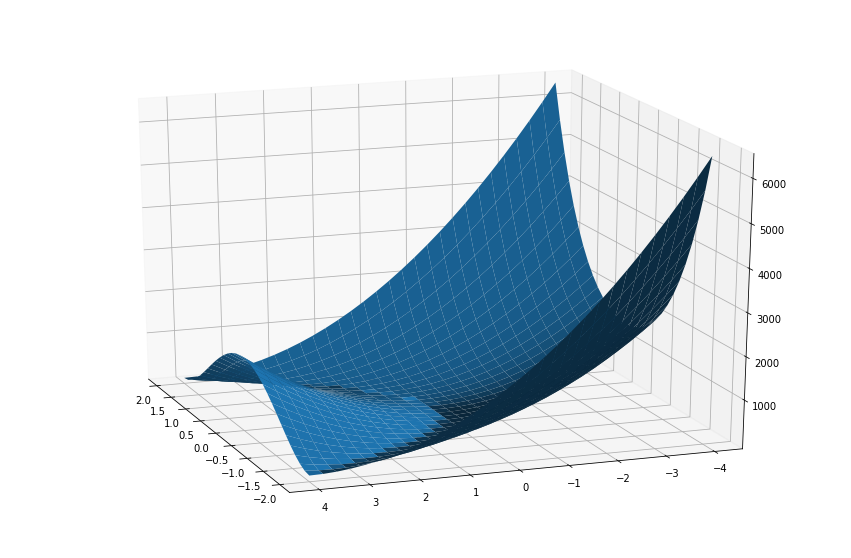

In [13]:
def fct(x, y):
    f, _, _ = Rosenbrock(np.array([x, y]))
    return f

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = [15, 10]
from mpl_toolkits.mplot3d import axes3d
meshx = np.linspace(-2, 2, 30)
meshy = np.linspace(-4, 4, 30)
X, Y = np.meshgrid(meshx, meshy)
Z = fct(X, Y)
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.view_init(20, 160)
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, edgecolor = 'none')
plt.show()

# Optimization

In [14]:
x0 = np.array([-1.5, 1.5])
eps = 1.0e-7
sol, iters = NewtonLineSearch(Rosenbrock, x0, eps, 10000)
print(f'The optimal solution is {sol} and is reached after {len(iters)-1} iterations.')
fopt, gopt, _ = Rosenbrock(sol)
print(f'f(x*)={fopt}, ||g(x*)||={np.linalg.norm(gopt)}')

The optimal solution is [1. 1.] and is reached after 24 iterations.
f(x*)=0.0, ||g(x*)||=0.0


## Plot the iterations on the contours

In [15]:
def plotIterations(xmin, xmax, ymin, ymax):
    xlist = np.linspace(xmin, xmax, 1000)
    ylist = np.linspace(ymin, ymax, 1000)
    X, Y = np.meshgrid(xlist, ylist)
    Z = fct(X, Y)
    plt.rcParams["figure.figsize"] = [15, 10]
    plt.contour(X, Y, Z, 20)
    xiter = [k[0][0] for k in iters]
    yiter = [k[0][1] for k in iters]
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.plot(xiter, yiter, linewidth=1, color='r', marker='+')
    plt.plot(1, 1, marker='*')
    plt.show()

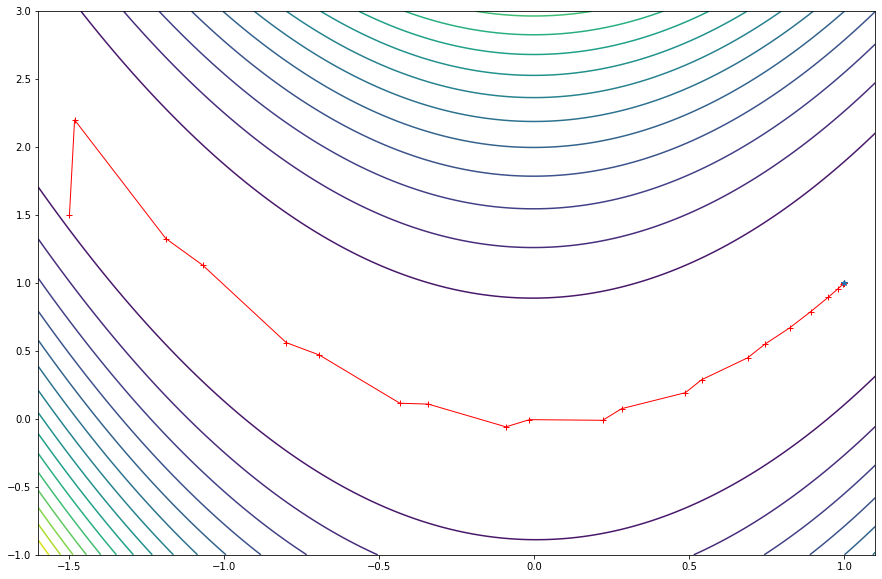

In [16]:
plotIterations(-1.6, 1.1, -1, 3) 

We can see that the zigzagging behavior observed for the steepest descent algorithm does not occur anymore. Below, we provide some details about the iterations.

In [17]:
print("    f(xk)    ||Grad(xk)||\talpha\t\ttau")
for k in iters:
    f, g, _ = Rosenbrock(k[0])
    ng = np.linalg.norm(g)
    print(f'{f:9.3g}\t{ng:9.3g}\t{k[2]}\t{k[3]}')

    f(xk)    ||Grad(xk)||	alpha		tau
     62.5	      479	None	None
     6.17	     5.13	0	1.0
     5.55	     48.9	0	0.125
      4.3	     10.6	0	1.0
     3.88	     33.2	0	0.5
     2.88	      6.9	0	1.0
     2.59	     21.4	0	0.5
     1.81	     4.19	0	1.0
     1.64	     14.2	0	0.5
     1.04	     2.37	0	1.0
    0.953	     12.3	0	0.5
    0.518	     1.26	0	1.0
    0.458	     11.6	0	0.5
    0.213	     0.64	0	1.0
    0.153	     7.52	0	0.5
   0.0671	    0.701	0	1.0
   0.0376	     2.78	0	0.5
   0.0139	      1.7	0	1.0
  0.00374	     1.27	0	1.0
 0.000516	    0.412	0	1.0
 1.99e-05	    0.121	0	1.0
 4.55e-08	  0.00439	0	1.0
  2.7e-13	 1.46e-05	0	1.0
 9.48e-24	 6.35e-11	0	1.0
        0	        0	0	1.0


It is observed that $\tau$ is always 0, so that the second derivatives matrix was always positive definite. The last eight iterations purely applied the local Newton method, with the step $\alpha=1$.